In [63]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def conc(vects):
    x, y = vects
    conc1 = concatenate([x,y])
    return conc1

def conc_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],256)

def kl_div(p,q):
    return K.sum((p*K.abs(K.log(p)-K.log(q)))/K.max((p*K.abs(K.log(p)-K.log(q)))
                            , axis=1, keepdims=True),axis=1, keepdims=True)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    x = y_pred[:,0:128]
    y = y_pred[:,128:268]
    y_pred1 = euclidean_distance(x,y)
    p = x
    q = y
    p = K.clip(p, K.epsilon(), 1)
    q = K.clip(q, K.epsilon(), 1)
    #y_true1 = y_true[:,0]
    #y_true1 = K.reshape(y_true1,(-1,))
    #print(y_true1)
    #tr_same = y_true[:,1]
    #tr_same = K.reshape(tr_same, (-1,))
    y_true1 = y_true
    tr_same = K.round(y_true/3)
    margin = 1
    test = 0.01*kl_div(p,q)
    contra = (y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))
    return K.mean((1-tr_same)*contra
                 + (tr_same)*test)
    

def create_pairs(x, y, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    for i in range(0,1500):
        k1 = random.randrange(0,x.shape[0])
        k2 = random.randrange(0, y.shape[0])
        pairs+= [[x[k1],y[k2]]]
        labels += [3]
    return np.array(pairs), np.array(labels)


def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Conv2D(30, (5, 5), input_shape=(28, 28,1), activation='relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))
    seq.add(Dropout(0.2))
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(128, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



In [64]:
seed=7
numpy.random.seed(seed)

In [65]:
X_test=[]
for i in range(0,10):
    for j in range(1,201):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_test.append(arr)
X_test=np.array(X_test)
#X_train=X_train.reshape(2000,784)
X_test=X_test.astype('float32')

print(X_test.shape)

(2000, 784)


In [66]:
y_test=[]

for i in range(0,10):
    for j in range(1,201):
        y_test.append(i)
        
y_test=np.array(y_test)

num_classes = 10
print(y_test.shape)

(2000,)


In [67]:
X_train= []
for i in range(0,10):
    for j in range(201,1801):
        img = PIL.Image.open("/home/aniruddha/Documents/USPSdataset/%d/%d.jpg" %(i,j)).convert("L")
        arr = np.array(img)
        # ravel to convert 28x28 to 784 1D array
        arr=arr.ravel()
        X_train.append(arr)
X_train=np.array(X_train)
#X_train=X_train.reshape(19000,784)
X_train=X_train.astype('float32')

print(X_train.shape)

(16000, 784)


In [68]:
#X_train = X_train.reshape(X_train.shape[0], 1, 28, 28).astype('float32')
#X_test = X_test.reshape(X_test.shape[0], 1, 28, 28).astype('float32')

print(X_train.shape)
print(X_test.shape)

(16000, 784)
(2000, 784)


In [69]:
X_train=X_train/255
X_test=X_test/255

In [70]:
y_train=[]

for i in range(0,10):
    for j in range(201,1801):
        y_train.append(i)
        
y_train=np.array(y_train)

num_classes = 10
print(y_train.shape)
print(y_test.shape)

(16000,)
(2000,)


In [71]:
print(y_train)
print(y_test)

[0 0 0 ... 9 9 9]
[0 0 0 ... 9 9 9]


In [72]:
input_dim = 784
nb_epoch = 5

In [73]:
(X1_train,y1_train), (X1_test, y1_test) = mnist.load_data()
X1_train=X1_train/255
X1_test=X1_test/255
X1_train = X1_train.astype('float32')
X1_test = X1_test.astype('float32')
X1_train = X1_train.reshape(-1,784)
X1_test = X1_test.reshape(-1,784)

In [74]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, X1_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, X1_test, digit_indices)

In [75]:
base_network = create_base_network()

In [76]:

X_temp=X_train.reshape(-1,28,28,1)
input_dim = X_temp.shape[1:]
print(input_dim)

(28, 28, 1)


In [77]:

# network definition
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 28, 28, 1)


In [78]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc, output_shape=conc_shape)([processed_a, processed_b])

model = Model(input=[input_a, input_b], output=distance)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  


In [79]:
print(distance.shape)
r = distance
r = K.reshape(r, (-1,256))
print(r.shape)

(?, 256)
(?, 256)


In [80]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [81]:
tr_pairs1=tr_pairs.reshape(-1,2,28,28,1)
te_pairs1=te_pairs.reshape(-1,2,28,28,1)

print(tr_pairs1.shape)
print(te_pairs1.shape)

(33480, 2, 28, 28, 1)
(5480, 2, 28, 28, 1)


In [82]:
print(tr_pairs1[:,0].shape)

(33480, 28, 28, 1)


In [83]:
print(tr_pairs[:, 1])

[[0.         0.00784314 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00784314 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


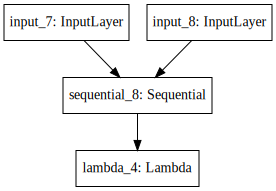

In [265]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

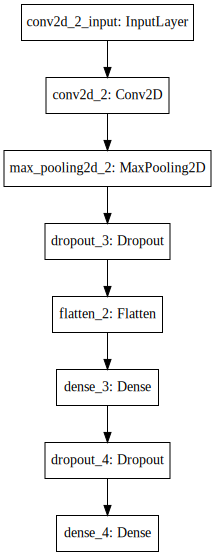

In [18]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [84]:
nb_epoch=5

In [85]:
# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs1[:,0], tr_pairs1[:, 1]], tr_y,
          validation_data=([te_pairs1[:,0], te_pairs1[:, 1]], te_y),
          batch_size=128,
          nb_epoch=nb_epoch)



/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 33480 samples, validate on 5480 samples
Epoch 1/5
33480/33480 [==============================] - 27s 820us/step - loss: 0.1304 - val_loss: 0.0755
Epoch 2/5
33480/33480 [==============================] - 28s 833us/step - loss: 0.0665 - val_loss: 0.0600
Epoch 3/5
33480/33480 [==============================] - 27s 818us/step - loss: 0.0435 - val_loss: 0.0500
Epoch 4/5
33480/33480 [==============================] - 28s 834us/step - loss: 0.0314 - val_loss: 0.0470
Epoch 5/5
33480/33480 [==============================] - 28s 842us/step - loss: 0.0235 - val_loss: 0.0440


In [105]:
(X_train1,y_train1),(X_test1,y_test1)=mnist.load_data()
X_test1 = X_test1/255
X_test1 = X_test1.astype('float32')

In [106]:
X_test1 = X_test1.reshape(-1,28,28,1)
print(X_test1.shape)

(10000, 28, 28, 1)


In [88]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [89]:
def plot_embedding(mu, Y, title=None):
    num_class = 1000 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple']
    l = [i for i in range(10)]
    alphas = 0.3 * np.ones(10)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(10):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9]), 
               ('0','1','2','3','4','5','6','7','8','9'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [107]:
X_test1=X_test1.reshape(-1,28,28,1)
processed=test_model.predict(X_test1)

In [90]:
X_train = X_train.reshape(-1,28,28,1)
processed=test_model.predict(X_train)

In [94]:
print(processed.shape)

(10000, 128)


Computing t-SNE embedding


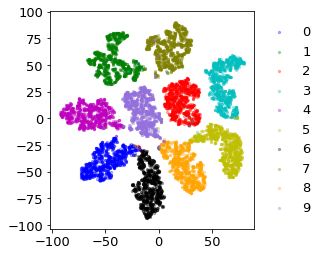

In [43]:
#latest model
#tsne of test - mnist dataset
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_train,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


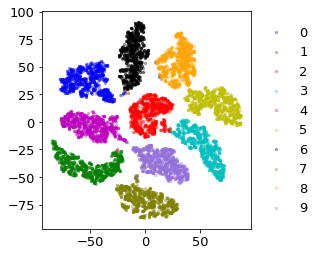

In [92]:
#new
#tsne of test - mnist dataset
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_train,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


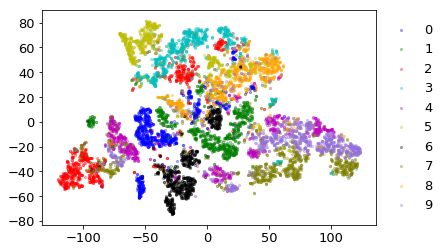

In [45]:
#latest model
#tsne of test - mnist dataset
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing t-SNE embedding


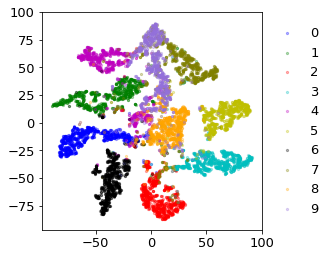

In [95]:
#new
#tsne of test - mnist dataset
print("Computing t-SNE embedding")
tsne_pred = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne_pred = tsne_pred.fit_transform(processed)

plot_embedding(X_tsne_pred, y_test1,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

In [96]:
X_train11=X_train.reshape(-1,28,28,1)
X_test11=X_test.reshape(-1,28,28,1)

In [97]:
processed_train=test_model.predict(X_train11)
processed_test=test_model.predict(X_test11)

In [98]:
num_pixels = 128
processed_train = processed_train.reshape(processed_train.shape[0], num_pixels).astype('float32')
processed_test = processed_test.reshape(processed_test.shape[0], num_pixels).astype('float32')

print(num_pixels)
print(processed_train.shape)
print(processed_test.shape)

128
(16000, 128)
(2000, 128)


In [99]:
from keras.utils import np_utils
y_train1 = np_utils.to_categorical(y_train)
y_test1 = np_utils.to_categorical(y_test)
num_classes = 10

In [100]:
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [101]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train1, validation_data=(processed_test, y_test1), epochs=10, batch_size=200, verbose=1)
# Final evaluation of the model
scores_test = model1.evaluate(processed_test, y_test1, verbose=1)
scores_train = model1.evaluate(processed_train, y_train1, verbose=1)


Train on 16000 samples, validate on 2000 samples
Epoch 1/10
16000/16000 [==============================] - 0s 30us/step - loss: 1.9178 - acc: 0.8740 - val_loss: 1.3382 - val_acc: 0.9410
Epoch 2/10
16000/16000 [==============================] - 0s 14us/step - loss: 0.6944 - acc: 0.9938 - val_loss: 0.4072 - val_acc: 0.9470
Epoch 3/10
16000/16000 [==============================] - 0s 16us/step - loss: 0.1780 - acc: 0.9949 - val_loss: 0.2339 - val_acc: 0.9490
Epoch 4/10
16000/16000 [==============================] - 0s 15us/step - loss: 0.0790 - acc: 0.9949 - val_loss: 0.1970 - val_acc: 0.9485
Epoch 5/10
16000/16000 [==============================] - 0s 15us/step - loss: 0.0498 - acc: 0.9949 - val_loss: 0.1862 - val_acc: 0.9500
Epoch 6/10
16000/16000 [==============================] - 0s 15us/step - loss: 0.0374 - acc: 0.9948 - val_loss: 0.1833 - val_acc: 0.9510
Epoch 7/10
16000/16000 [==============================] - 0s 16us/step - loss: 0.0309 - acc: 0.9949 - val_loss: 0.1828 - val_acc:

In [102]:
#scores_train=scores_train/1.0
#scores_test=scores_test/1.0
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 99.53%
* Accuracy on test set: 95.05%


In [108]:
from keras.utils import np_utils
y_test1 = np_utils.to_categorical(y_test1)
num_classes = 10

In [109]:
scores_test_USPS=model1.evaluate(processed, y_test1, verbose=1)
print('* Accuracy on test USPS set: %0.2f%%' % (100 * scores_test_USPS[1]))

10000/10000 [==============================] - 0s 18us/step
* Accuracy on test USPS set: 80.70%
